In [ ]:
# !pip install --upgrade --quiet networkx

In [23]:
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import deque
from sklearn.preprocessing import scale
from sklearn.metrics import precision_score, recall_score
from sklearn.linear_model import Lasso

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
def partial_correlation(d, i, j):
    """ Estimate partial correlation between i and j """
    om = np.linalg.inv(np.cov(d.T))
    return - om[i,j] / np.sqrt(om[i,i] * om[j,j])

def partial_correlation_ols(d, i, j, z):
    """ Estimate partial correlation between i and j conditional on z"""
    fit = lambda i: sm.OLS(data[:, [i]], data[:, z]).fit()
    return np.corrcoef(fit(i).resid, fit(j).resid)[0,1]

def plot_dag(dag, layout = nx.kamada_kawai_layout): 
    """ Plots our DAGs with edge weights and labels """
    graph = nx.from_numpy_array(np.abs(dag.adjacency), create_using = nx.DiGraph)
    pos = layout(graph)
    weights = [d['weight'] for i,j,d in graph.edges.data()]
    edges = nx.draw_networkx_edges(graph, pos, edge_cmap = plt.cm.Blues, edge_color = weights)
    labels = nx.draw_networkx_labels(graph, pos)
    nodes = nx.draw_networkx_nodes(graph, pos, with_labels = True)

    pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    pc.set_array(weights)
    plt.colorbar(pc)

In [3]:
def emom(tau, N):
    """ Exponential MoM prior @DavidRossel """ #eMoM distribution to generate weight of the tree branches -> easy to learn 
    dat = np.zeros(0)
    while True:
        draw = np.random.normal(0,1,N)
        prob = np.exp( - tau / draw**2)
        idx = prob > np.random.uniform(0, 1, N)
        dat = np.concatenate([dat, draw[idx]])
        if len(dat) >= N:
            return dat[:N]

class DAG(): # Directed acyclic graph
    def __init__(self, tot, avg_children = 3, noise = .5):
        self.noise = noise #Each child  is a linear combination of a parent and noise CHILD = w*PARENT + noise 
        self.lam = avg_children # Mean Poisson distribution 
        self.i = 0
        self.sorted_adjacency = np.zeros((tot,tot))
        self.new_children = deque([0])
        self.tot = tot
        self.nodes = False

    def _shuffle(self, a):
        n = a.shape[0]
        self.idx = np.random.choice(range(n), size = n, replace=False)
        return a[self.idx].T[self.idx].T
    
    def generate_nodes(self):
        """ Implements a breadth-first generation of nodes """
        while self.new_children:
            i = self.new_children.pop()
            left = self.tot - self.i            
            children = np.random.poisson(self.lam, 1)[0]            
            children = children if left - children >= 0 else left
            connections = [self.i + i for i in range(children)]
            
            # Generates random normal 0,1 edges
            self.sorted_adjacency[i, connections] = emom(.9, children)
            self.i += children
            for c in connections:
                self.new_children.appendleft(c)
            

        # Retry if we did not get a full graph
        if self.i != self.tot:
            self.__init__(self.tot)
            self.generate_nodes()
        
        # Shuffle to get random indices
        self.adjacency = self._shuffle(self.sorted_adjacency) # Adjacency matrix containing the weight of the branches
        self.nodes = True

    def _data(self, n):
        self.data = np.zeros((n,self.tot))
        for i,col in enumerate(self.sorted_adjacency.T):
            dat = self.data.dot(col)
            if np.all(dat == 0):
                dat = np.random.normal(0,1,n)
            self.data[:,i] = dat + np.random.normal(0,self.noise,n)
        return self.data
    
    def generate_data(self, n):
        """ Generates data according to the implied adjacency matrix

        Every node is their parent, times the coefficient in the
        adjacency matrix, plus additive gaussian noise (sd = self.noise).
        """
        if not self.nodes:
            self.generate_nodes()
        dat = self._data(n)
        dat = dat.T[self.idx].T
        return scale(dat)

In [4]:
dag = DAG(50, noise=.5)

In [5]:
data = dag.generate_data(100)

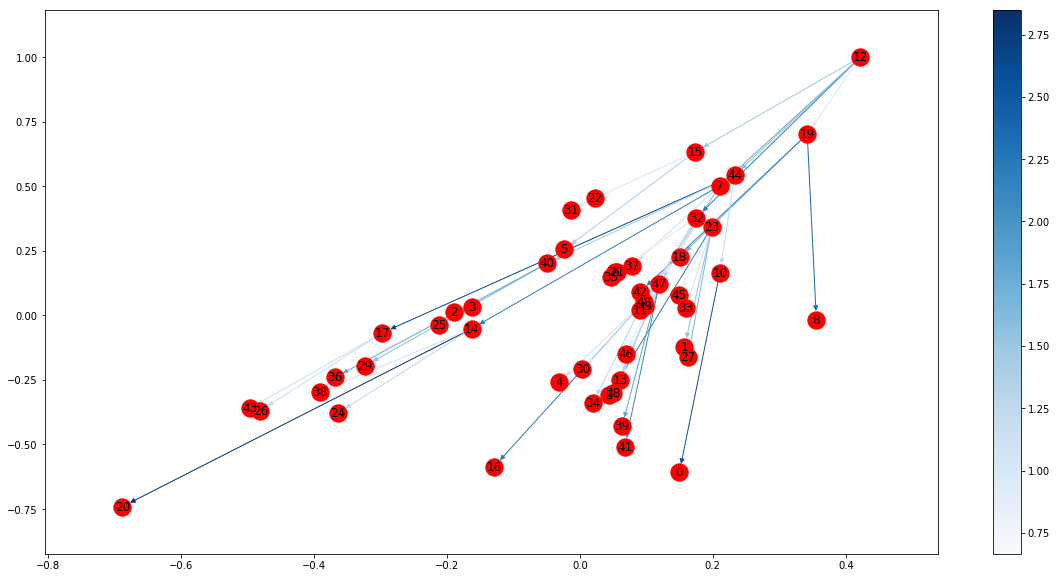

In [24]:
plot_dag(dag)

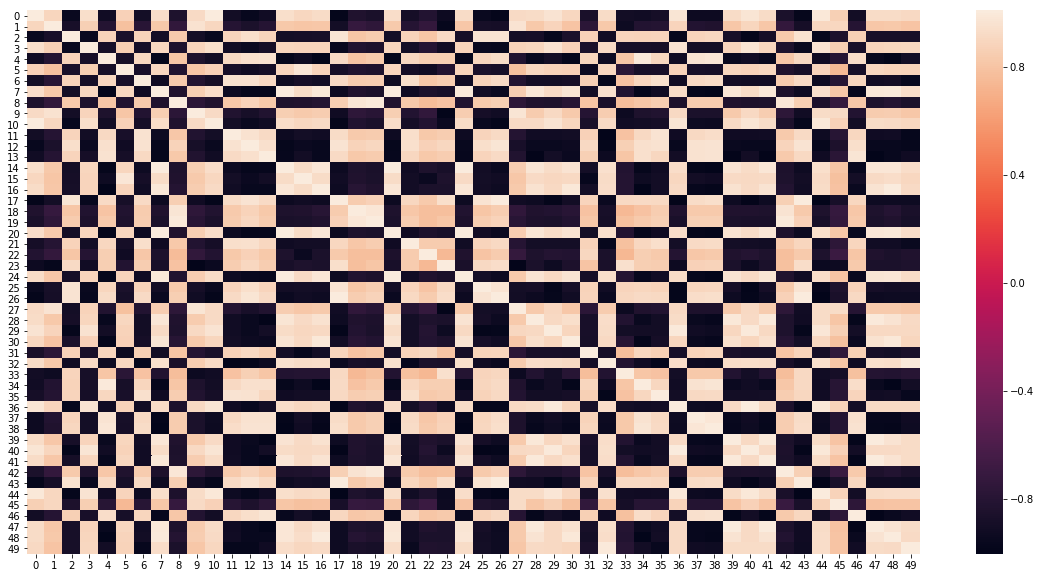

In [25]:
sns.heatmap(np.cov(data.T))

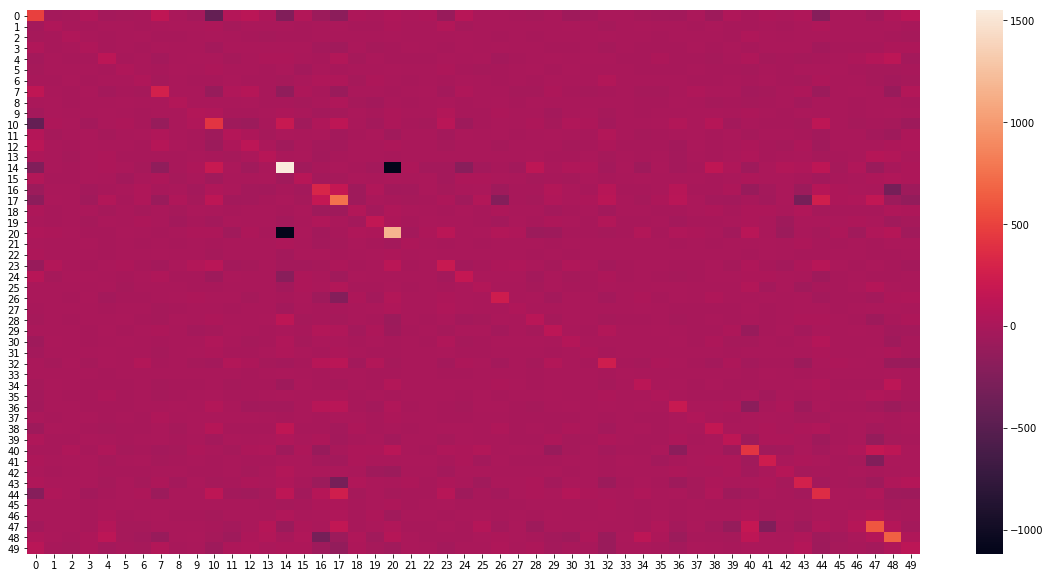

In [26]:
sns.heatmap(np.linalg.inv((np.cov(data.T))))

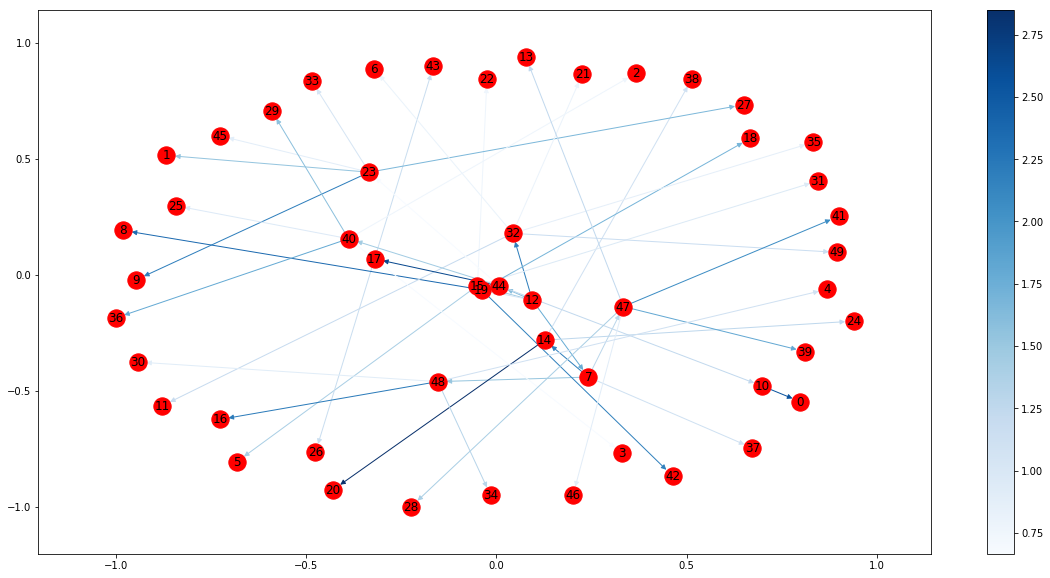

In [27]:
plot_dag(dag, layout = nx.spring_layout)

In [28]:
# Pick a target variable (y) by looking at the above plot.
# Let the rest of the data be potential predictors

def pick(d, i):
    return d[:, i], np.delete(d, i, 1)

y, X = pick(scale(data), 29)

In [29]:
clf = Lasso(alpha = 0.1)
clf.fit(X, y, check_input=True)
print(clf.coef_)
[i for i, e in enumerate(clf.coef_) if e != 0]

[ 0.          0.         -0.          0.         -0.          0.
 -0.          0.         -0.          0.          0.         -0.
 -0.         -0.          0.          0.          0.         -0.
 -0.         -0.          0.         -0.         -0.         -0.
  0.         -0.         -0.          0.          0.          0.
 -0.          0.         -0.         -0.         -0.          0.03662004
 -0.         -0.          0.          0.85560515  0.         -0.
 -0.          0.          0.         -0.          0.          0.
  0.        ]


[35, 39]

In [30]:
# Take a look at the results from OLS. 
# 1. Are they reasonable? 
# 2. Are there any spurious correlations? 
print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                     117.0
Date:                Fri, 10 May 2019   Prob (F-statistic):           2.05e-39
Time:                        00:38:20   Log-Likelihood:                 94.639
No. Observations:                 100   AIC:                            -91.28
Df Residuals:                      51   BIC:                             36.38
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0245      0.293      0.083      0.9

In [31]:
# Given your perfect knowledge of the true DGP,
# pick a reduced form model and run OLS regression. 
# Does this look like a better model?
def recover_adj(data, precision):
    adj_list = []
    for i in range(50):
        y, X = pick(scale(data), i)
        clf = Lasso(alpha = precision)
        clf.fit(X, y, check_input=True)
        neighbours =[]
        for j, e in enumerate(clf.coef_):
            if e != 0:
                if j > i:
                    neighbours.append(j+1)
                else:
                    neighbours.append(j)
        adj_list.append([i,neighbours])
    return adj_list
        
    

In [32]:
# Clearly, we have a large graph, but we're only interested in 
# the part that is local to our target variable (y).
# Try to find this minimal model via model selection,
# over local linear models: 


In [33]:
# Take a look at partial correlations between a pair of data points.
# See how this evolves as N (number of observations) grows.

In [34]:
# Now let's try to recover the ENTIRE precision matrix
# via a series of local regressions

In [35]:
def fill_diag(arr):
    """ Fills out an array with ones in the diagonal """
    P = arr.shape[0]
    a = np.ones((P,P))
    for i,c in enumerate(arr):
        a[i] = np.insert(c, i, 1)
    return a

def symmetrize(a, union):
    """ Makes adjacency matrix symmetric """
    c = (np.tril(a).T + np.triu(a))
    m = (c + c.T)

    # union or intersection
    if union:
        return m.astype(bool).astype(int)
    else: 
        return (m >= 2).astype(int)

def coefs_to_adjacency(a, union = True):
    """ Converts a 2D numpy array of coefficients into adjacency matrix 

    union: To use the union of the non-zero coefficients of symmetric
    regressions. If False, uses the intersection.
    """
    return symmetrize(fill_diag(a), union)

def score_adjacency(predicted_adj, dag):
    """ Score predicted adjacency matrix
    
    Calculates precision and recall scores of an adjacency matrix
    against the truth of the original DAG instance.    
    """
    preds = predicted_adj.reshape(-1)
    y = np.abs(dag.adjacency).astype(bool).astype(int).reshape(-1)    
    return precision_score(y, preds), recall_score(y, preds)

def regress(data, alpha, fn):
    """ Runs local regressions for each feature in dataset """
    d = [pick(data, i) for i in range(data.shape[1])]
    coefs = [fn(y,X,alpha) for y,X in d]
    return np.array(coefs)

In [36]:
# Create a function, with one tuning parameter, alpha,
# that performs a local regression and returns a 1/0 array
# where an index has 1 if the feature is to be "included", 
# and 0 otherwise.

def fn_a(y, X, alpha):
    clf = Lasso(alpha = alpha)
    clf.fit(X, y, check_input=True)
    neighbours =[]
    for j, e in enumerate(clf.coef_):
        if e != 0:
            neighbours.append(1)
        else:
            neighbours.append(0)
    return neighbours

def fn_b(y, X, alpha):
    pass

In [44]:
# Test your regression function and compare

coefs = regress(data, .25, fn_a)
predicted_adj = coefs_to_adjacency(coefs, True)

score_adjacency(predicted_adj, dag)

(0.2578947368421053, 0.98)

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


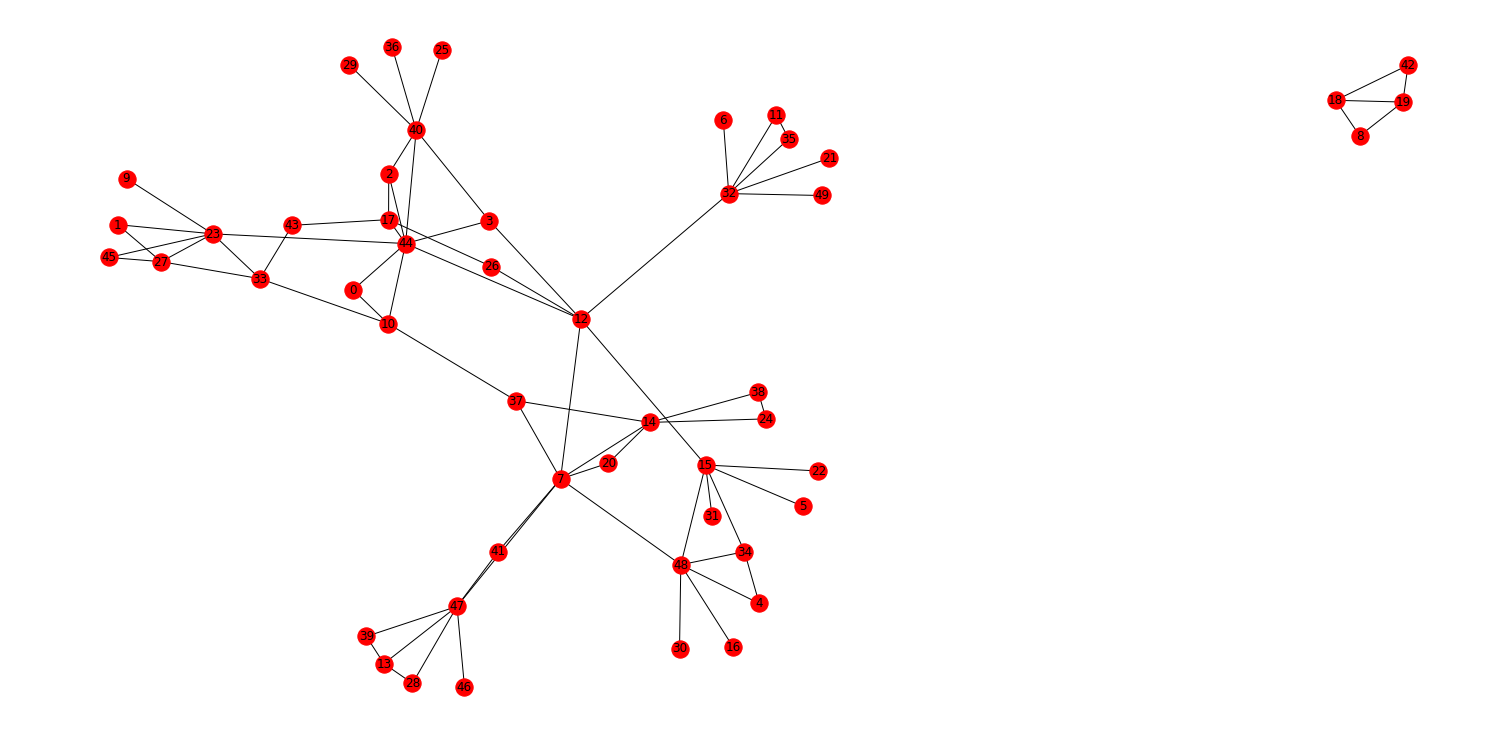

In [38]:
# Visualize your predicted adjacency matrix
G = nx.from_numpy_array(predicted_adj)
nx.draw(G, with_labels=True, layout = nx.spring_layout)

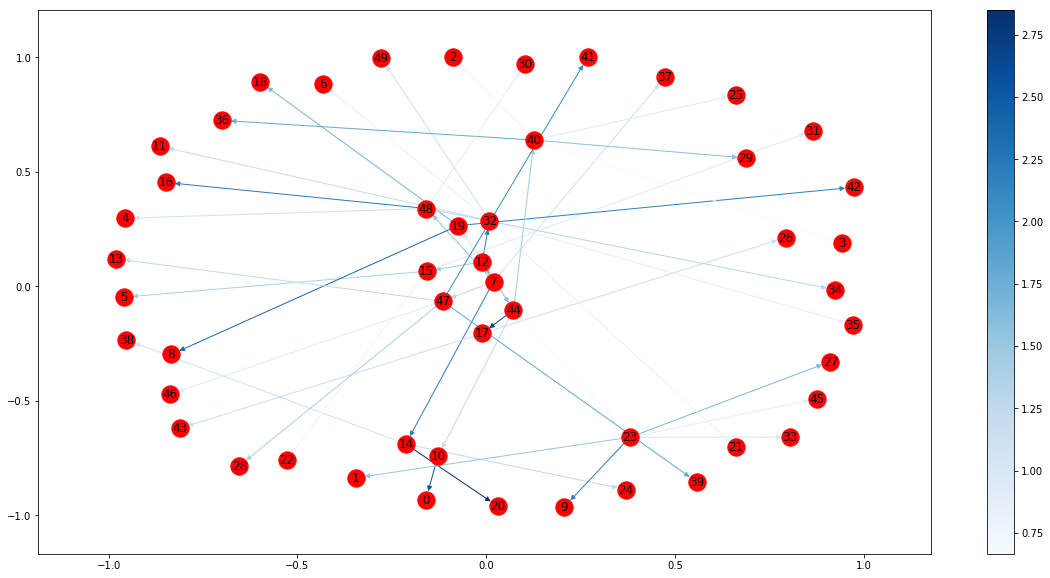

In [39]:
plot_dag(dag, layout = nx.spring_layout)

/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


TypeError: 'LineCollection' object is not iterable

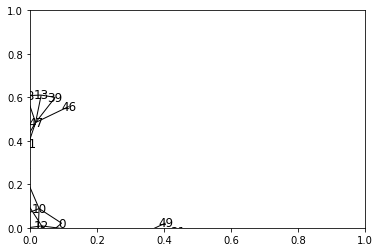

In [22]:
layout = nx.spring_layout
pos = layout(G)
edges = nx.draw_networkx_edges(G, pos, edge_cmap = plt.cm.Blues)
labels = nx.draw_networkx_labels(G, pos)
pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Blues)
plt.colorbar(pc)